In [1]:
#base
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
#keras
import keras.backend as K
import tensorflow as tf 
from tensorflow.keras import losses
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
#sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


from scipy.spatial import distance
from scipy.stats import spearmanr


2022-02-25 12:48:33.733553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 12:48:33.733594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [3]:
def history_to_df(results):
    
    results_df = pd.DataFrame.from_dict(results.history)
    results_df.columns = ['loss', 'val_loss']
    results_df['epoch'] = results_df.index
    
    return results_df

def plot_history(results_df):
    
    sns.lineplot(x = results_df['epoch'], y = results_df['loss'], color = 'black')
    sns.lineplot(x = results_df['epoch'], y = results_df['val_loss'], color = 'orange', linestyle = '--')
    
    b = mpatches.Patch(color='black', label='train')
    o = mpatches.Patch(color='orange', label='test')

    plt.legend(handles=[b, o], shadow = False)

    plt.show()

In [4]:
def calculate_BC(HISTORY, PREDICTION):
    
    PREDICTION.index = HISTORY.index
    
    BRAY_CURTIS = []

    for idx in HISTORY.index:

        y_true = HISTORY.loc[idx]
        y_forecasted = PREDICTION.loc[idx]

        bray_curtis = distance.braycurtis(y_true,
                                          y_forecasted)

        BRAY_CURTIS.append(bray_curtis)

    bray_curtis_df = pd.DataFrame(BRAY_CURTIS,
                              columns = ['bc_distance'])

    bray_curtis_df['timestep'] = HISTORY.index
    
    return bray_curtis_df

def calculate_MAE_timestep(HISTORY, PREDICTION):
    
    PREDICTION.index = HISTORY.index
    
    MAE = []

    for idx in HISTORY.index:

        y_true = HISTORY.loc[idx]
        y_forecasted = PREDICTION.loc[idx]

        divider = y_true.max() - y_true.min()
        mae = mean_absolute_error(y_true,y_forecasted)
        nmae = mae/divider

        MAE.append(mae)

    mae_df = pd.DataFrame(MAE, columns = ['mae'])

    mae_df['timestep'] = HISTORY.index
    
    return mae_df

def calculate_MAE_bacteria(PREDICTION, HISTORY):
    
    MAE = []

    for col in HISTORY.columns:
        x = HISTORY[col]
        y = PREDICTION[col]
    
        divider = x.max() - x.min()
        mae = mean_absolute_error(x,y)
        nmae = mae/divider
        MAE.append(nmae)

    mae_df = pd.DataFrame(MAE, columns = ['mae'])
    mae_df['otu'] = HISTORY.columns
    
    return mae_df


def calculate_spearman_rho(PREDICTION, HISTORY):
    
    RHO_imputed = []
    PVAL = []

    for col in HISTORY.columns:
        x = HISTORY[col]
        y = PREDICTION[col]

        rho, pval = spearmanr(x, y)
        RHO_imputed.append(rho)
    

    rho = pd.DataFrame(RHO_imputed, columns = ['rho'])
    rho['otu'] = HISTORY.columns
    
    return rho

In [ ]:
def plot_otu(prediction, title):
    
    col = 'TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTGCGTAGACGGGAAGGTAAGTTAGTTGTGAAATCCCTCGGCTCAACTGAGGAACTG'

    plt.figure(figsize = [10, 3])
    sns.lineplot(x = x_test[1:].index, y = x_test[1:][col], color = 'black', linewidth = .7)
    sns.scatterplot(x = x_test[1:].index, y = x_test[1:][col], color = 'black')

    sns.lineplot(x = prediction[:-1].index, y = prediction[:-1][col], color = 'orange', linewidth = .7)
    sns.scatterplot(x = prediction[1:].index, y = prediction[1:][col], color = 'orange')

    b = mpatches.Patch(color='black', label='true')
    o = mpatches.Patch(color='orange', label='predicted')

    plt.legend(handles=[b, o], shadow = True)
    plt.title(title)
    plt.ylabel('')
    b = mpatches.Patch(color='black', label='true')
    o = mpatches.Patch(color='orange', label='predicted')

    plt.legend(handles=[b, o], shadow = False)
    
    #plt.savefig('{}.png'.format(title))

In [5]:
%cd /home/MCB/zkarwowska/AE

/home/MCB/zkarwowska/AE


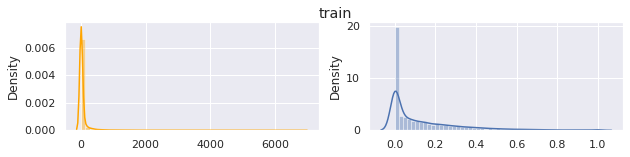

<Figure size 432x288 with 0 Axes>

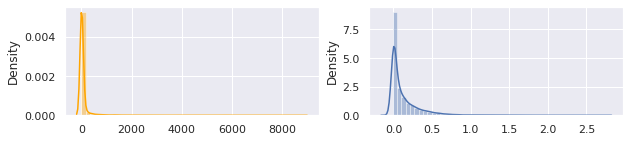

In [6]:
#read data
df = pd.read_csv('rarefied_double_interpolated_feces_male_otu.csv', index_col =[0])
keep_otu = pd.DataFrame(df.describe().loc['mean']).sort_values(by = ['mean'], ascending = False).head(200).index.tolist()
filtered_df = df[keep_otu]
filtered_df = filtered_df.drop(['TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGAATGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTG',
                               'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTG',
                               'TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGTGCGTAGACGGGAAAACAAGTTAGTTGTGAAATCCCTCGGCTTAACTGAGGAACTG'], axis = 1)

#split to train and test
x_train = filtered_df.iloc[:220]
x_test = filtered_df.iloc[221:]
#scale
scaler = MinMaxScaler()
normalized_train = scaler.fit_transform(x_train)
normalized_test = scaler.transform(x_test)

#plot distribution after scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 2])
plt.suptitle('train')
ax1 = sns.distplot(x_train, ax = ax1, color = 'orange')
ax2 = sns.distplot(normalized_train, ax = ax2)
plt.show()

plt.suptitle('test')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [10, 2])
ax1 = sns.distplot(x_test, ax = ax1, color = 'orange')
ax2 = sns.distplot(normalized_test, ax = ax2)
plt.show()

# global weights, mae loss

In [85]:
#%cd ae_svar/keras_svar_model/

/home/MCB/zkarwowska/AE/ae_svar/keras_svar_model


In [7]:
class LossBrayCurtis(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossBrayCurtis, self).__init__(name='bray_curtis')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        sum = tf.math.abs(y_true + y_pred)
        value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)
        return value
    
    
class LossMAE(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossMAE, self).__init__(name='mean_absolute_error')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        value = tf.math.reduce_mean(diff, axis=1)
        
        return value

In [9]:
def keras_svar_model(l1, l2, normalized_train, normalized_test):
    
    l1 = l1
    l2 = l2
    input_size = normalized_train.shape[1]
    input_data = tf.keras.Input(shape=(input_size,))
    #svar
    svar_layer = tf.keras.layers.Dense(input_size, kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2))
    svar_pred = svar_layer(input_data)
    #output
    output = tf.keras.layers.Dense(input_size)(svar_pred)
    #model
    svar_model = tf.keras.Model(input_data, output)
    BrayCurtisLoss = LossBrayCurtis(None, None)
    svar_model.compile(
        #loss = tf.keras.losses.MeanAbsoluteError(),   
        loss = BrayCurtisLoss,
        optimizer='Adam'
    )
    svar_model.run_eagerly = True

    #train
    svar_model_result = svar_model.fit(normalized_train[:-1], normalized_train[1:],
                                       epochs=100,
                                       batch_size=16,
                                       shuffle=False,
                                       validation_data=(normalized_test[:-1], normalized_test[1:]),
                                       verbose = 0
    )
    
    return svar_model, svar_model_result

In [10]:
model_0001, _ = keras_svar_model(0.001, 0.001, normalized_train, normalized_test)

pred_0001 = model_0001.predict(normalized_test)
pred_denorm_0001 = scaler.inverse_transform(pred_0001)
pred_denorm__0001_df = pd.DataFrame(pred_denorm_0001, columns = filtered_df.columns)
pred_denorm__0001_df[pred_denorm__0001_df<0] = 0

2022-02-25 12:49:03.405851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 12:49:03.405881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 12:49:03.405899: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zuza-large-instance): /proc/driver/nvidia/version does not exist
2022-02-25 12:49:03.406105: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


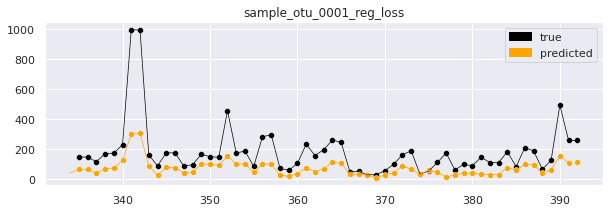

In [81]:
plot_otu(pred_denorm__0001_df, 'sample_otu_0001_reg_loss')

# keras svar autoencoderdef keras_svar_model(l1, l2, normalized_train, normalized_test):


In [19]:
class LossBrayCurtis(losses.Loss):

    def __init__(self, y_true_transformer, y_pred_transformer):
        super(LossBrayCurtis, self).__init__(name='bray_curtis')
        self.y_true_transformer = y_true_transformer
        self.y_pred_transformer = y_pred_transformer

    def call(self, y_true, y_pred):
        #y_true = (y_true - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        #y_pred = (y_pred - K.constant(scaler.min_)) / K.constant(scaler.scale_)
        #y_pred = tf.nn.relu(y_pred)


        diff = tf.math.abs(y_true - y_pred)
        sum = tf.math.abs(y_true + y_pred)
        value = tf.reduce_sum(diff, axis=-1) / tf.reduce_sum(sum, axis=-1)
        return value

In [22]:

l1 = 1e-3
l2 = 1e-3

input_size = normalized_train.shape[1]
input_data = tf.keras.Input(shape=(input_size,))

encoder_layer = tf.keras.layers.Dense(256, activation='relu')(input_data)
#svar
svar_layer = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1, l2=l2))(encoder_layer)
#decoder
decoder_layer = tf.keras.layers.Dense(256, activation='relu')(svar_layer)
#output
output = tf.keras.layers.Dense(input_size)(decoder_layer)
#model
svar_model = tf.keras.Model(input_data, output)

BrayCurtisLoss = LossBrayCurtis(None, None)
svar_model.compile(
    #loss = tf.keras.losses.MeanAbsoluteError(),   
    loss = BrayCurtisLoss,
    optimizer='Adam'
)
svar_model.run_eagerly = True

#train
svar_model_result = svar_model.fit(normalized_train[:-1], normalized_train[1:],
                                   epochs=200,
                                   batch_size=16,
                                   shuffle=False,
                                   validation_data=(normalized_test[:-1], normalized_test[1:]),
                                   verbose = 0
)


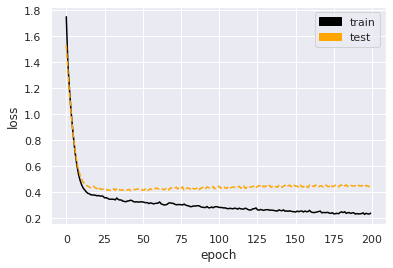

In [23]:
plot_history(history_to_df(svar_model_result)) #mteric - rho, tuning l1l2 on metric

In [46]:
encoder_model = tf.keras.Model(input_data, svar_layer)

encoded_input = tf.keras.Input(shape = (64))
decoder = svar_model.layers[-2](encoded_input)
decoder = svar_model.layers[-1](decoder)
decoder_model = tf.keras.Model(encoded_input, decoder)

encoded_test = encoder_model.predict(normalized_test)
decoded_test = decoder_model.predict(encoded_test)
decoded_test_denorm = scaler.inverse_transform(decoded_test)

In [47]:
decoded_test_denorm_df = pd.DataFrame(decoded_test_denorm, columns = filtered_df.columns)
decoded_test_denorm_df[decoded_test_denorm_df<0] = 0
decoded_test_denorm_df.index = x_test.index

Text(0, 0.5, '')

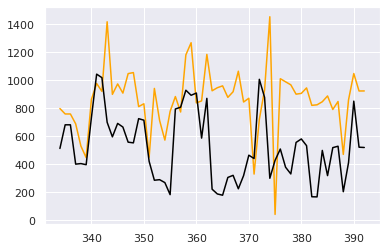

In [53]:
col = 'AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGACAAGTTGGAAGTGAAATCTATGGGCTCAACCCATAAACTG'
sns.lineplot(x = encoded_test_denorm_df.index, y = encoded_test_denorm_df[col], color = 'orange')
sns.lineplot(x = x_test.index, y = x_test[col], color = 'black')
plt.ylabel('')

In [ ]:
def extract_encoder_decoder(latent_layer, latent_dim, model):
    
    #encoder
    encoder_model = tf.keras.Model(input_data, latent_layer)

    #decoder
    encoded_input = tf.keras.Input(shape = (latent_dim))

    decoder = model.layers[-2](encoded_input)
    decoder = model.layers[-1](decoder)
    decoder_model = tf.keras.Model(encoded_input, decoder)

    return encoder_model, decoder_model

def predict_data(encoder_model, decoder_model, input_data):
    
    #predict
    encoded = encoder_model.predict(input_data)
    decoded = decoder_model.predict(encoded)
    decoded_denorm = scaler.inverse_transform(decoded)
    decoded_denorm[decoded_denorm<0] = 0
    decoded_denorm_df = pd.DataFrame(decoded_denorm, columns = filtered_df.columns)
    
    return decoded_denorm_df